# Will the album be popular?

# 1. Data processing 

In [2]:
from popularity_forecaster.jobs.data_preprocessing import DataPreprocessingWorkflow
from popularity_forecaster.jobs.feature_engineering import FeatureEngineeringWorkflow
from popularity_forecaster.jobs.train_model import TrainModelWorkflow
from popularity_forecaster.jobs.evaluate_model import EvaluateModelWorkflow
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from pathlib import Path
from collections import OrderedDict
from statistics import mean


import seaborn as sns
import numpy as np
import scipy
import itertools

from datetime import datetime
from joblib import Parallel, delayed

from scipy.stats import ttest_ind
from scipy.spatial.distance import seuclidean

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

/home/lorbi/Desktop/SIDE-PROJECTS/PriceNow/other/PN-Album-Popularity/.venv/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [24]:
workflow = DataPreprocessingWorkflow()
workflow.replace_unknown_genres()
df = workflow.remove_duplicate_reviews()
df.head()

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Studio 1,Studio 1,Andy Battaglia,8.5,2009,February 18 2009,Studio,Electronic,0.511917,0.499667,5.250000,-5.626583,0.031983,0.724917,0.024493,0.165367,0.555083,101.395167
1,John Fahey,The Great Santa Barbara Oil Slick,Mark Richardson,8.2,2005,February 13 2005,Water,Folk/Country,0.369765,0.325412,4.470588,-19.153824,0.148624,0.647053,0.559133,0.527782,0.179465,107.622647
2,Reigning Sound,Too Much Guitar,Stephen M. Deusner,8.3,2004,August 19 2004,In the Red,Electronic,0.253943,0.912857,4.428571,-1.089500,0.055500,0.000253,0.751214,0.199071,0.552786,133.895500
3,The Red Thread,After the Last,Chris Dahlen,7.3,2003,July 17 2003,Badman,Rock,0.425400,0.433474,5.700000,-12.871000,0.028260,0.310325,0.224137,0.125150,0.451400,104.354200
4,Mac Miller,Swimming,Evan Rytlewski,7.5,2018,August 3 2018,Warner Bros.,Rap,0.624846,0.438154,4.153846,-9.456077,0.170246,0.652462,0.012819,0.121131,0.281138,122.121308


## 1.1 album release distribution

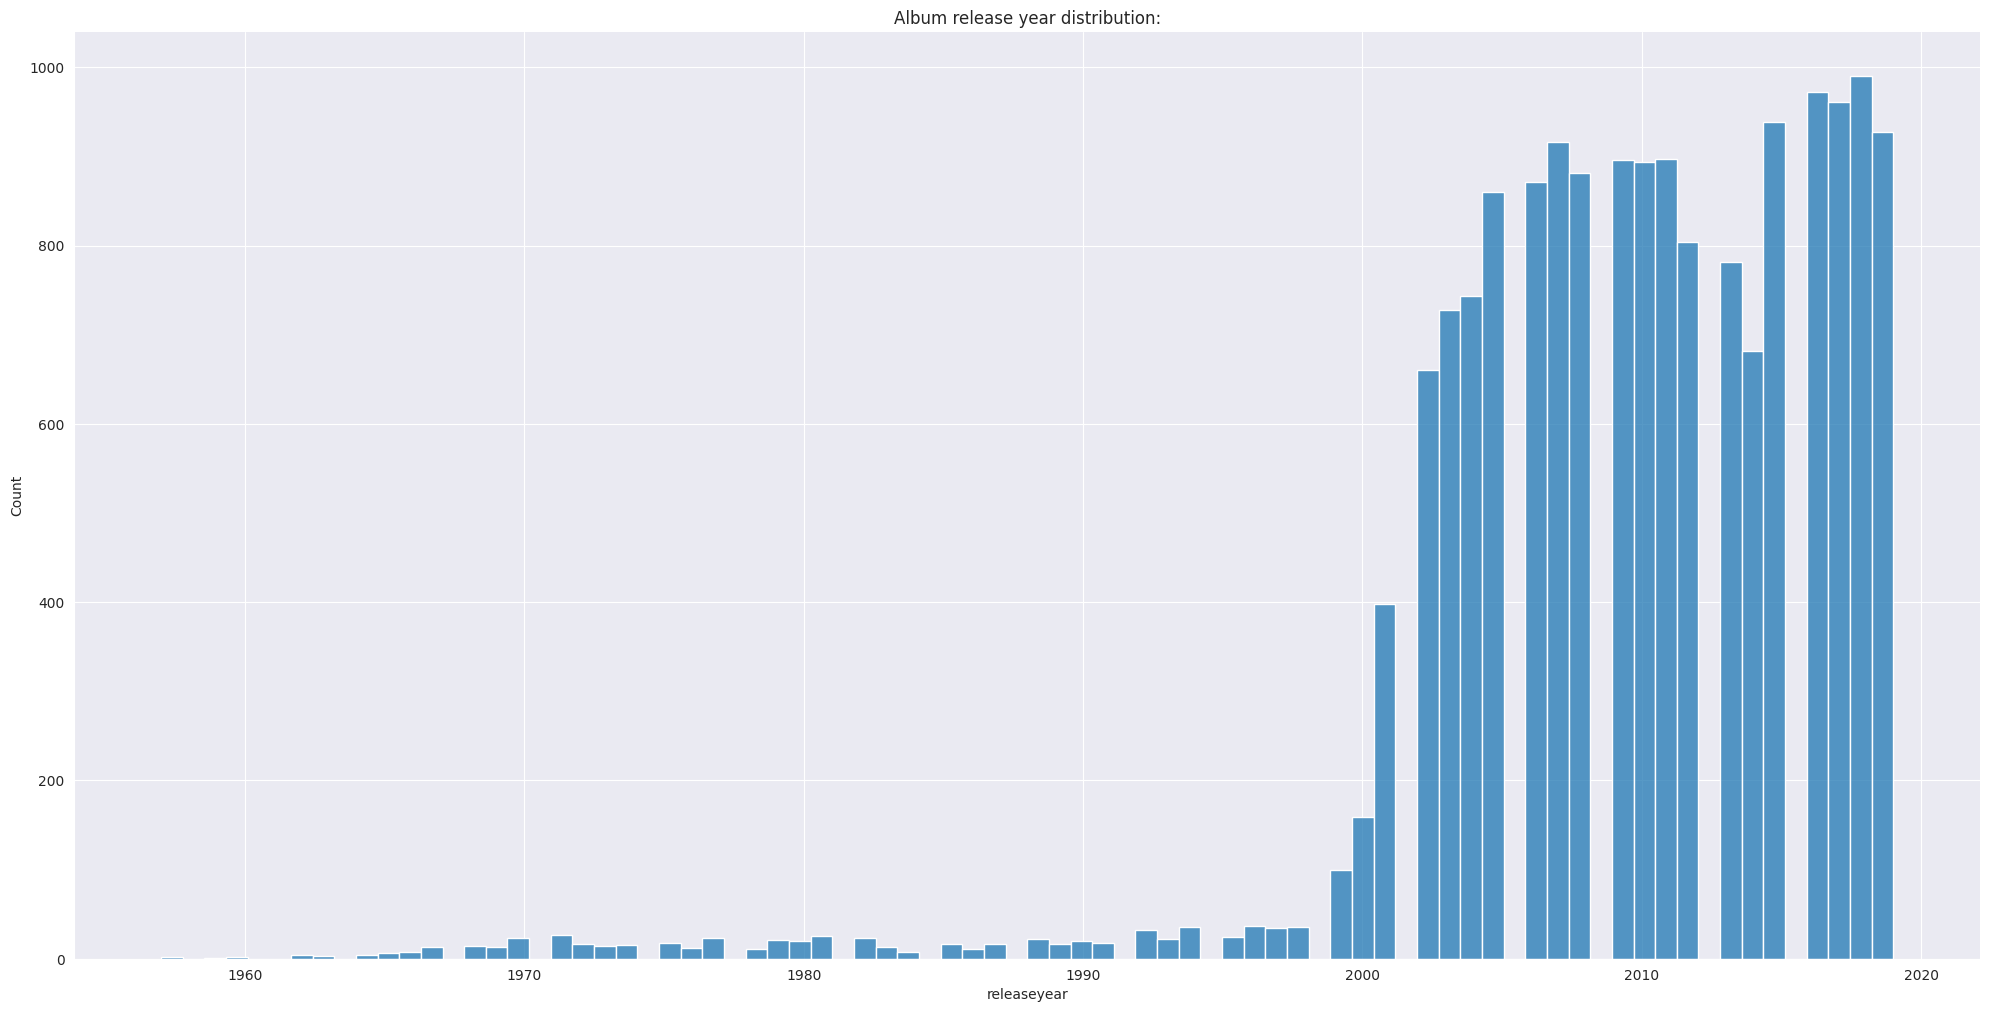

In [8]:
year_dist=sns.displot(df, x="releaseyear", height=10, aspect=2).set(title='Album release year distribution:')

## 1.2. The distribution of album release years and the average score of albums per year.

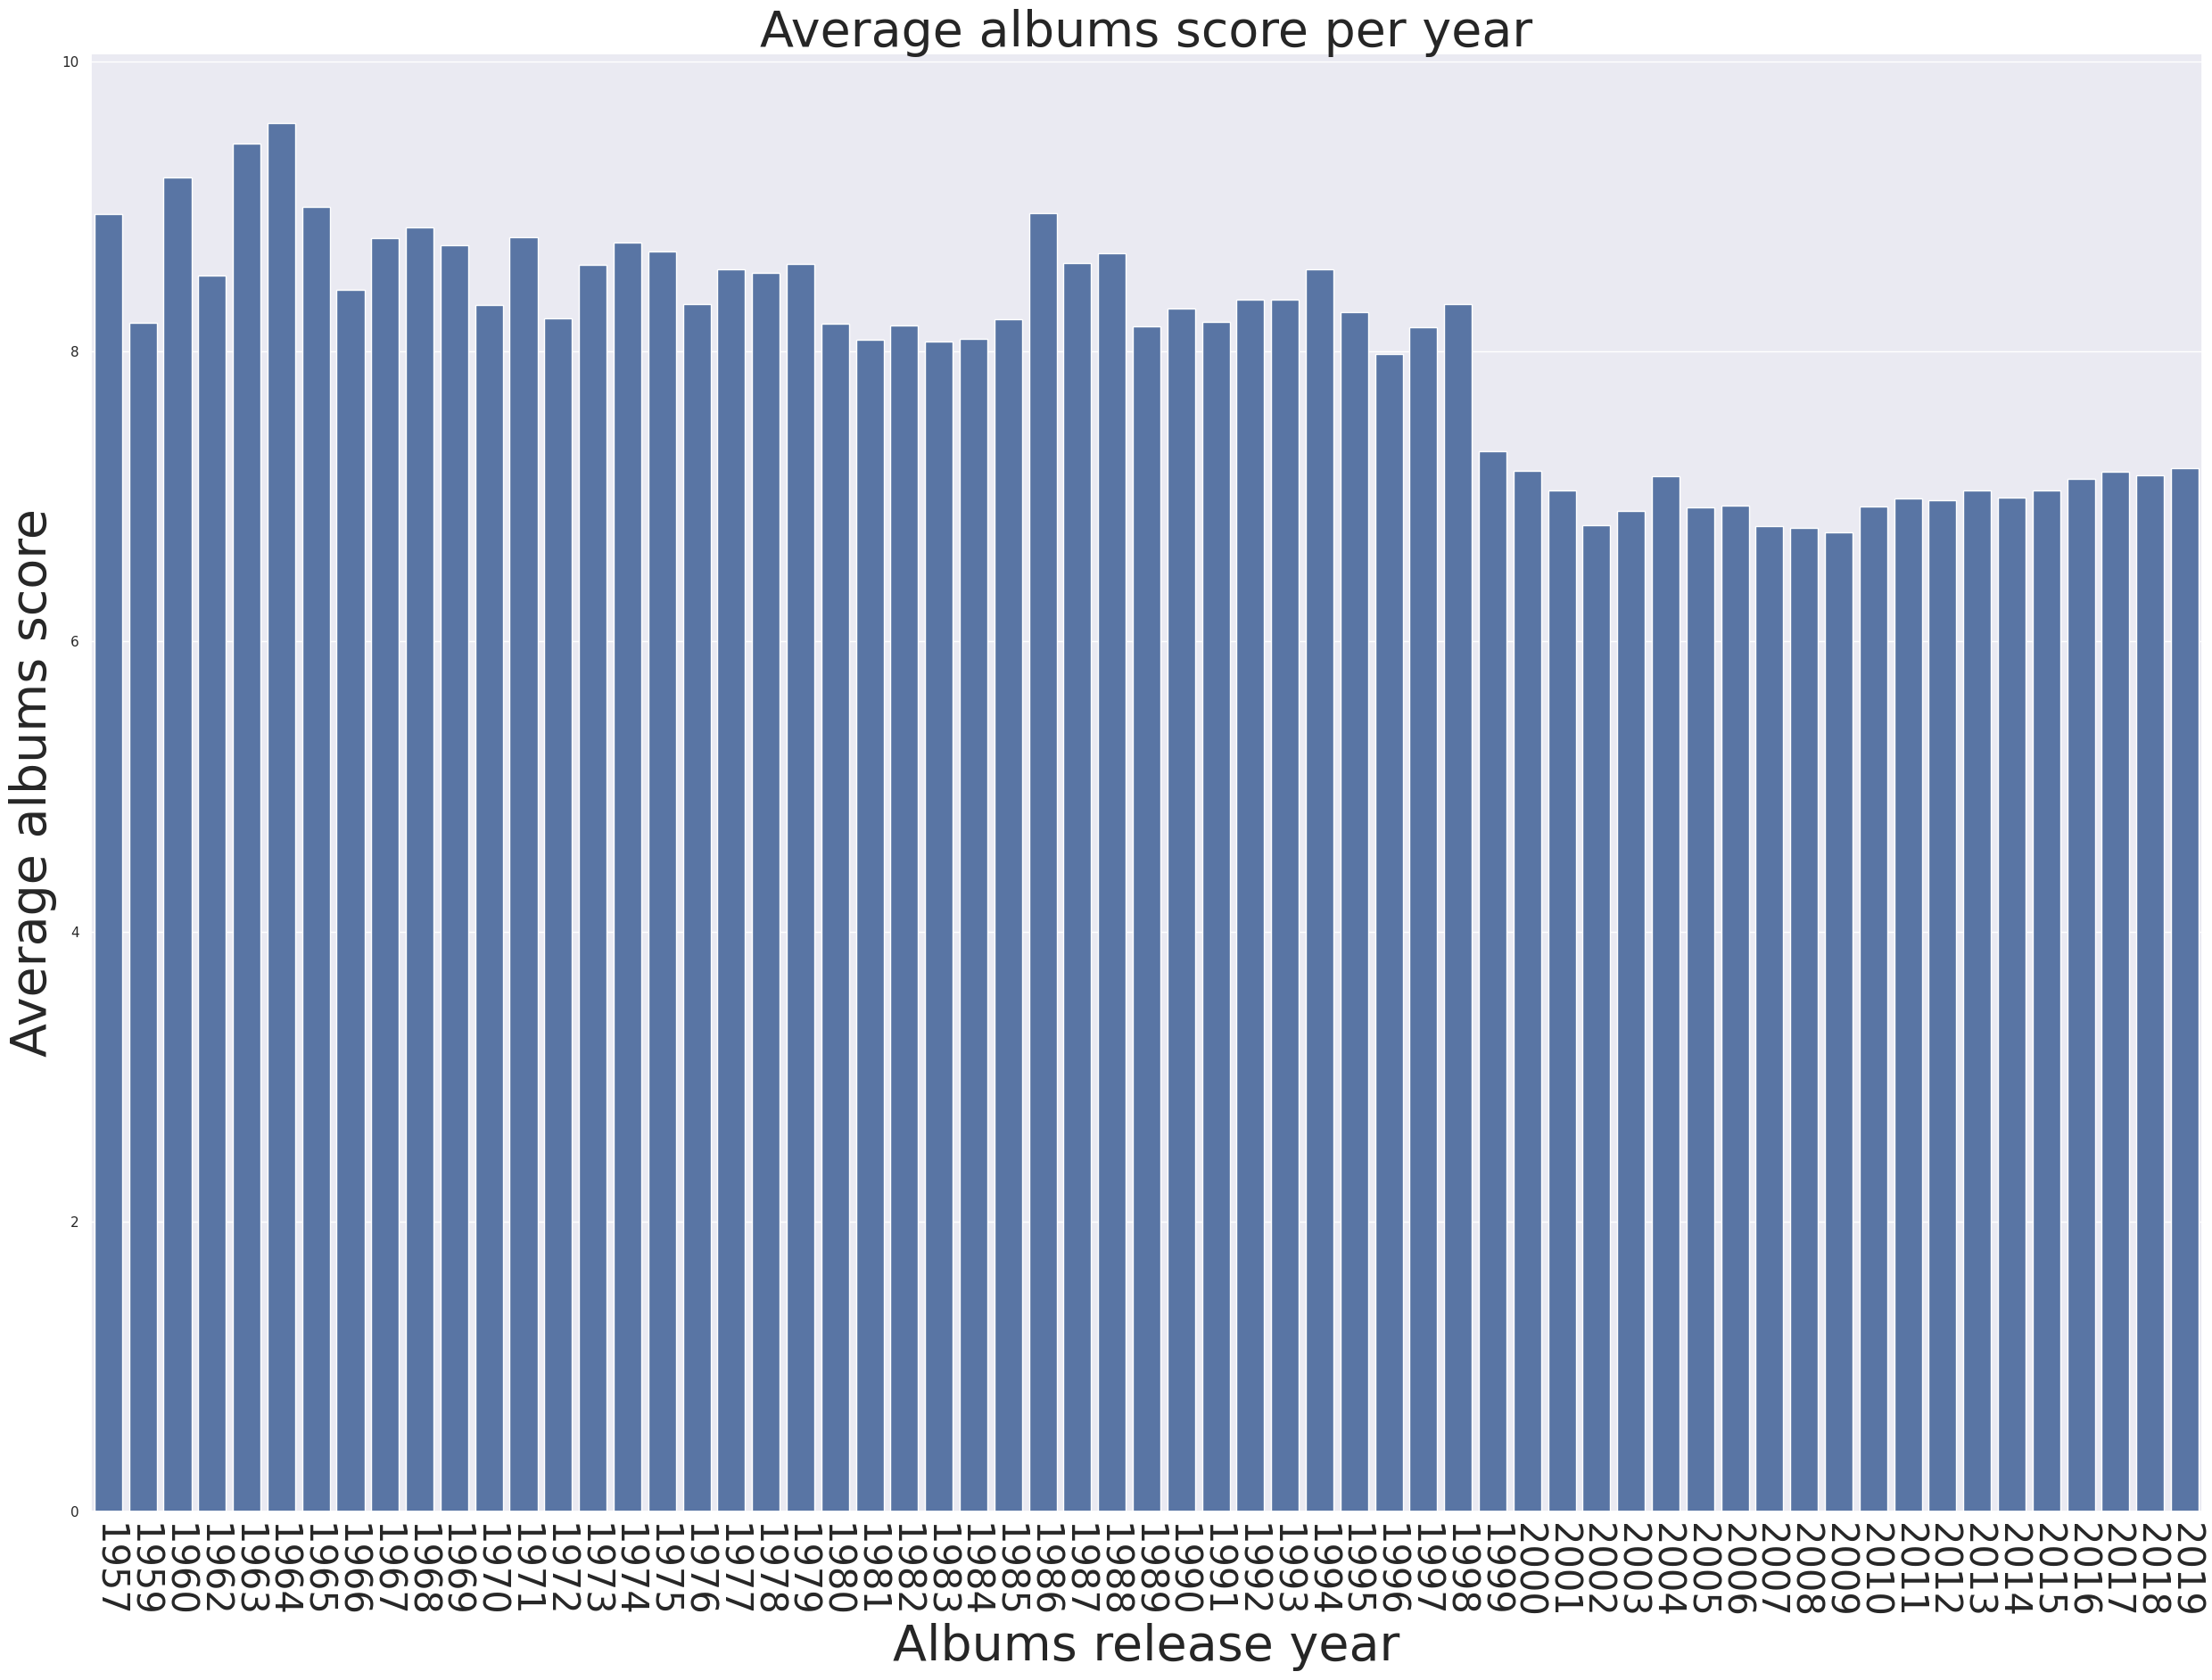

In [14]:

# Convert 'score' column to numeric, handling non-numeric values by converting them to NaN
df['score'] = pd.to_numeric(df['score'], errors='coerce')

# Group by 'releaseyear' and calculate the mean of the 'score' column
avgs = df.groupby("releaseyear")['score'].mean()

# Visualization
sns.set(rc={'figure.figsize':(25,19)})
plot = sns.barplot(x=avgs.index, y=avgs.values)
plot.set_xlabel("Albums release year", fontsize=40)
plot.set_ylabel("Average albums score", fontsize=40)
plot.set_title("Average albums score per year", fontsize=40)
plt.xticks(rotation=-90, fontsize=30)
plt.tight_layout()
plt.show()


In [22]:
df.describe()

,score,releaseyear,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,16743.000000,16743.000000,16743.000000,16743.000000,16743.000000,16743.000000,16743.000000,16743.000000,16743.000000,16743.000000,16743.000000,16743.000000
mean,7.048856,2009.329152,0.512228,0.601230,5.214575,-9.280727,0.090781,0.302058,0.274530,0.196438,0.405158,120.317143
std,1.248683,7.810108,0.158870,0.203125,1.612716,4.234315,0.090137,0.262345,0.298684,0.104912,0.182346,15.471767
min,0.000000,1957.000000,-1.000000,-1.000000,-1.000000,-51.728750,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,6.500000,2005.000000,0.408755,0.473833,4.333333,-11.214514,0.040628,0.091140,0.009709,0.134532,0.274000,111.241000
50%,7.300000,2010.000000,0.511200,0.624769,5.230769,-8.444125,0.056667,0.229000,0.149339,0.174267,0.406200,120.385538
75%,7.800000,2015.000000,0.622415,0.749630,6.100000,-6.394258,0.100328,0.460945,0.496185,0.228385,0.531692,129.112597
max,10.000000,2019.000000,0.974000,0.999000,11.000000,4.078000,0.958000,0.996000,0.982000,0.978000,0.971000,215.972000


# 2. Feature engineering

In [27]:
workflow = FeatureEngineeringWorkflow()
workflow.generate_hot_encoded()
x_train, x_test, y_train, y_test = workflow.generate_train_test_sets()
workflow.save_train_test_sets(x_train, x_test, y_train, y_test)

# 3. Model Training

In [9]:
workflow = TrainModelWorkflow()
workflow.fit_model()
workflow.save_model()
reg_model = workflow.model
x_test = workflow.x_test
y_test = workflow.y_test

# 4. Model evaluation

In [5]:
workflow = EvaluateModelWorkflow()
model = workflow.load_model_from_disk()
r2 = workflow.evaluate_model(model)

2024-06-01 22:50:00.500 | INFO     | popularity_forecaster.core.utils:summary:24 - Model version 0.2.0 summary:
2024-06-01 22:50:00.500 | INFO     | popularity_forecaster.core.utils:summary:25 - train size: 11720 test size: 5023
2024-06-01 22:50:00.502 | INFO     | popularity_forecaster.core.utils:summary:26 - R^2: 0.039428721809337985
2024-06-01 22:50:00.503 | INFO     | popularity_forecaster.core.utils:summary:27 - Mean squared error: 1.46
2024-06-01 22:50:00.504 | WARNING  | popularity_forecaster.jobs.evaluate_model:evaluate_model:28 - Model version 0.2.0 have greater R^2 than 0.3 


## 4.1 Residual plot - regression model

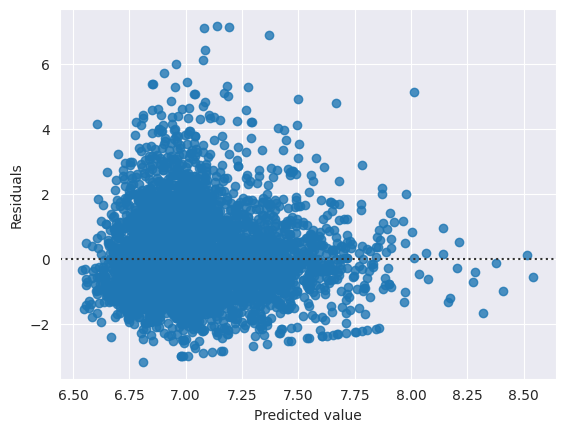

In [10]:
y_pred=reg_model.predict(x_test)
residuals=y_pred-y_test
df_residuals=pd.DataFrame({"Predicted value":y_pred, "Residuals":residuals})
sns.residplot(data=df_residuals, x="Predicted value", y="Residuals")
plt.show()

# 5. Experiments - let's break it!
## 5.1. I will create an alternate train-test split (hereinafter referred to as "the longitudinal split") where you train with data from albums released before 2000 and test with data from 2003 and after.  

In [41]:
def summary(model, x_train, y_train, x_test, y_test):
    """Prints model summary"""
    r2 = model.score(x_test, y_test)
    y_pred = model.predict(x_test)
    print("\n Model summary: ")
    print(f"train size: {x_train.shape[0]} test size: {x_test.shape[0]}")
    print(f"R^2: {r2}")
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

    return r2

In [42]:
workflow = DataPreprocessingWorkflow()
workflow.replace_unknown_genres()
df = workflow.remove_duplicate_reviews()
df.head()

before = df["releaseyear"] < 2000 
after = df["releaseyear"] > 2003 
hot_encoded = pd.get_dummies(df.genre)
hot_encoded.columns = list(map(lambda x: f"{x}_onehot", hot_encoded.columns))

features = [
    "releaseyear",
    "key",
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "loudness",
    "speechiness",
    "valence",
    "tempo",
] + list(hot_encoded.columns)
print(features)

df = df.join(hot_encoded)
x_alt_train = df[features][before].values
y_alt_train = df["score"][before].values

x_alt_test = df[features][after].values
y_alt_test = df["score"][after].values

y = df["score"].values
x = df[features].values

reg_2 = LinearRegression().fit(x_alt_train, y_alt_train)
r2_2 = summary(reg_2, x_alt_train, y_alt_train, x_alt_test, y_alt_test)

['releaseyear', 'key', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 'Electronic_onehot', 'Experimental_onehot', 'Folk/Country_onehot', 'Global_onehot', 'Jazz_onehot', 'Metal_onehot', 'Other_onehot', 'Pop/R&B_onehot', 'Rap_onehot', 'Rock_onehot']

 Model summary: 
train size: 783 test size: 14015
R^2: -0.27554611680794894
Mean squared error: 1.69


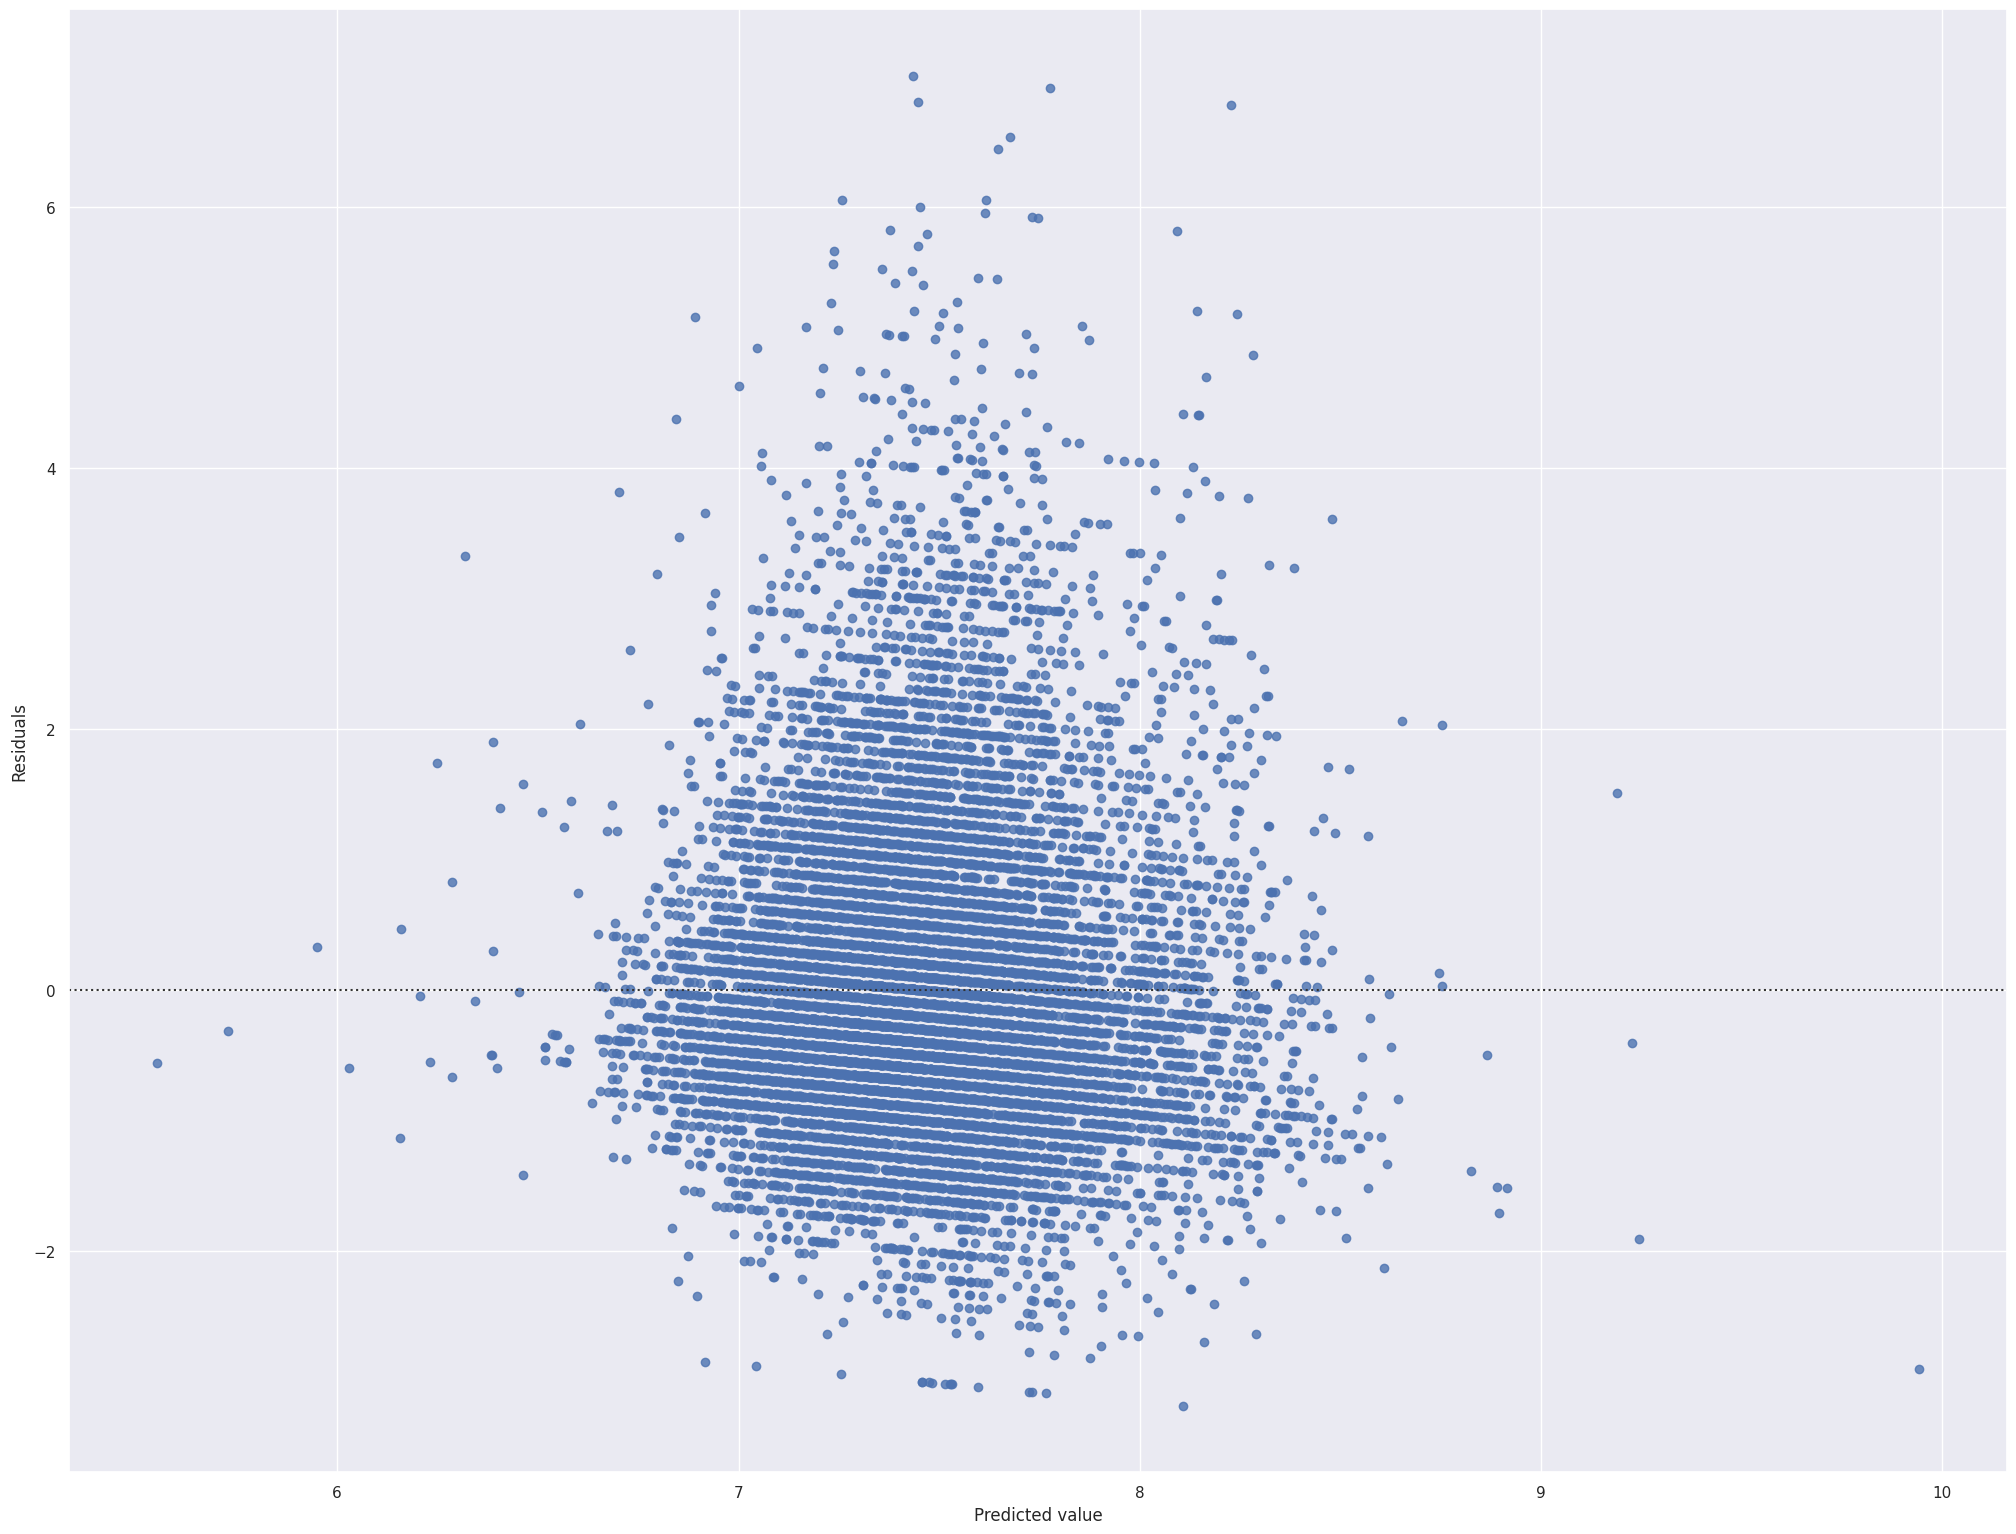

In [43]:
# plot the residuals 
y_pred=reg_2.predict(x_alt_test)
residuals=y_pred-y_alt_test
df_residuals=pd.DataFrame({"Predicted value": y_pred, "Residuals": residuals})
sns.residplot(data=df_residuals, x="Predicted value", y="Residuals")
plt.show()

In [44]:
# second model is performing worse
print(f"first model: {r2} second model: {r2_2}")

first model: 0.039428721809337985 second model: -0.27554611680794894


### Second model is performing worse

## 5.2. I will try with different model

In [45]:
# train gradient boosting model on alternative split from previous task
reg_3 = GradientBoostingRegressor(n_estimators=200).fit(x_alt_train, y_alt_train)
r2_3 = summary(reg_3, x_alt_train, y_alt_train, x_alt_test, y_alt_test)


 Model summary: 
train size: 783 test size: 14015
R^2: -0.46950877441141414
Mean squared error: 1.95


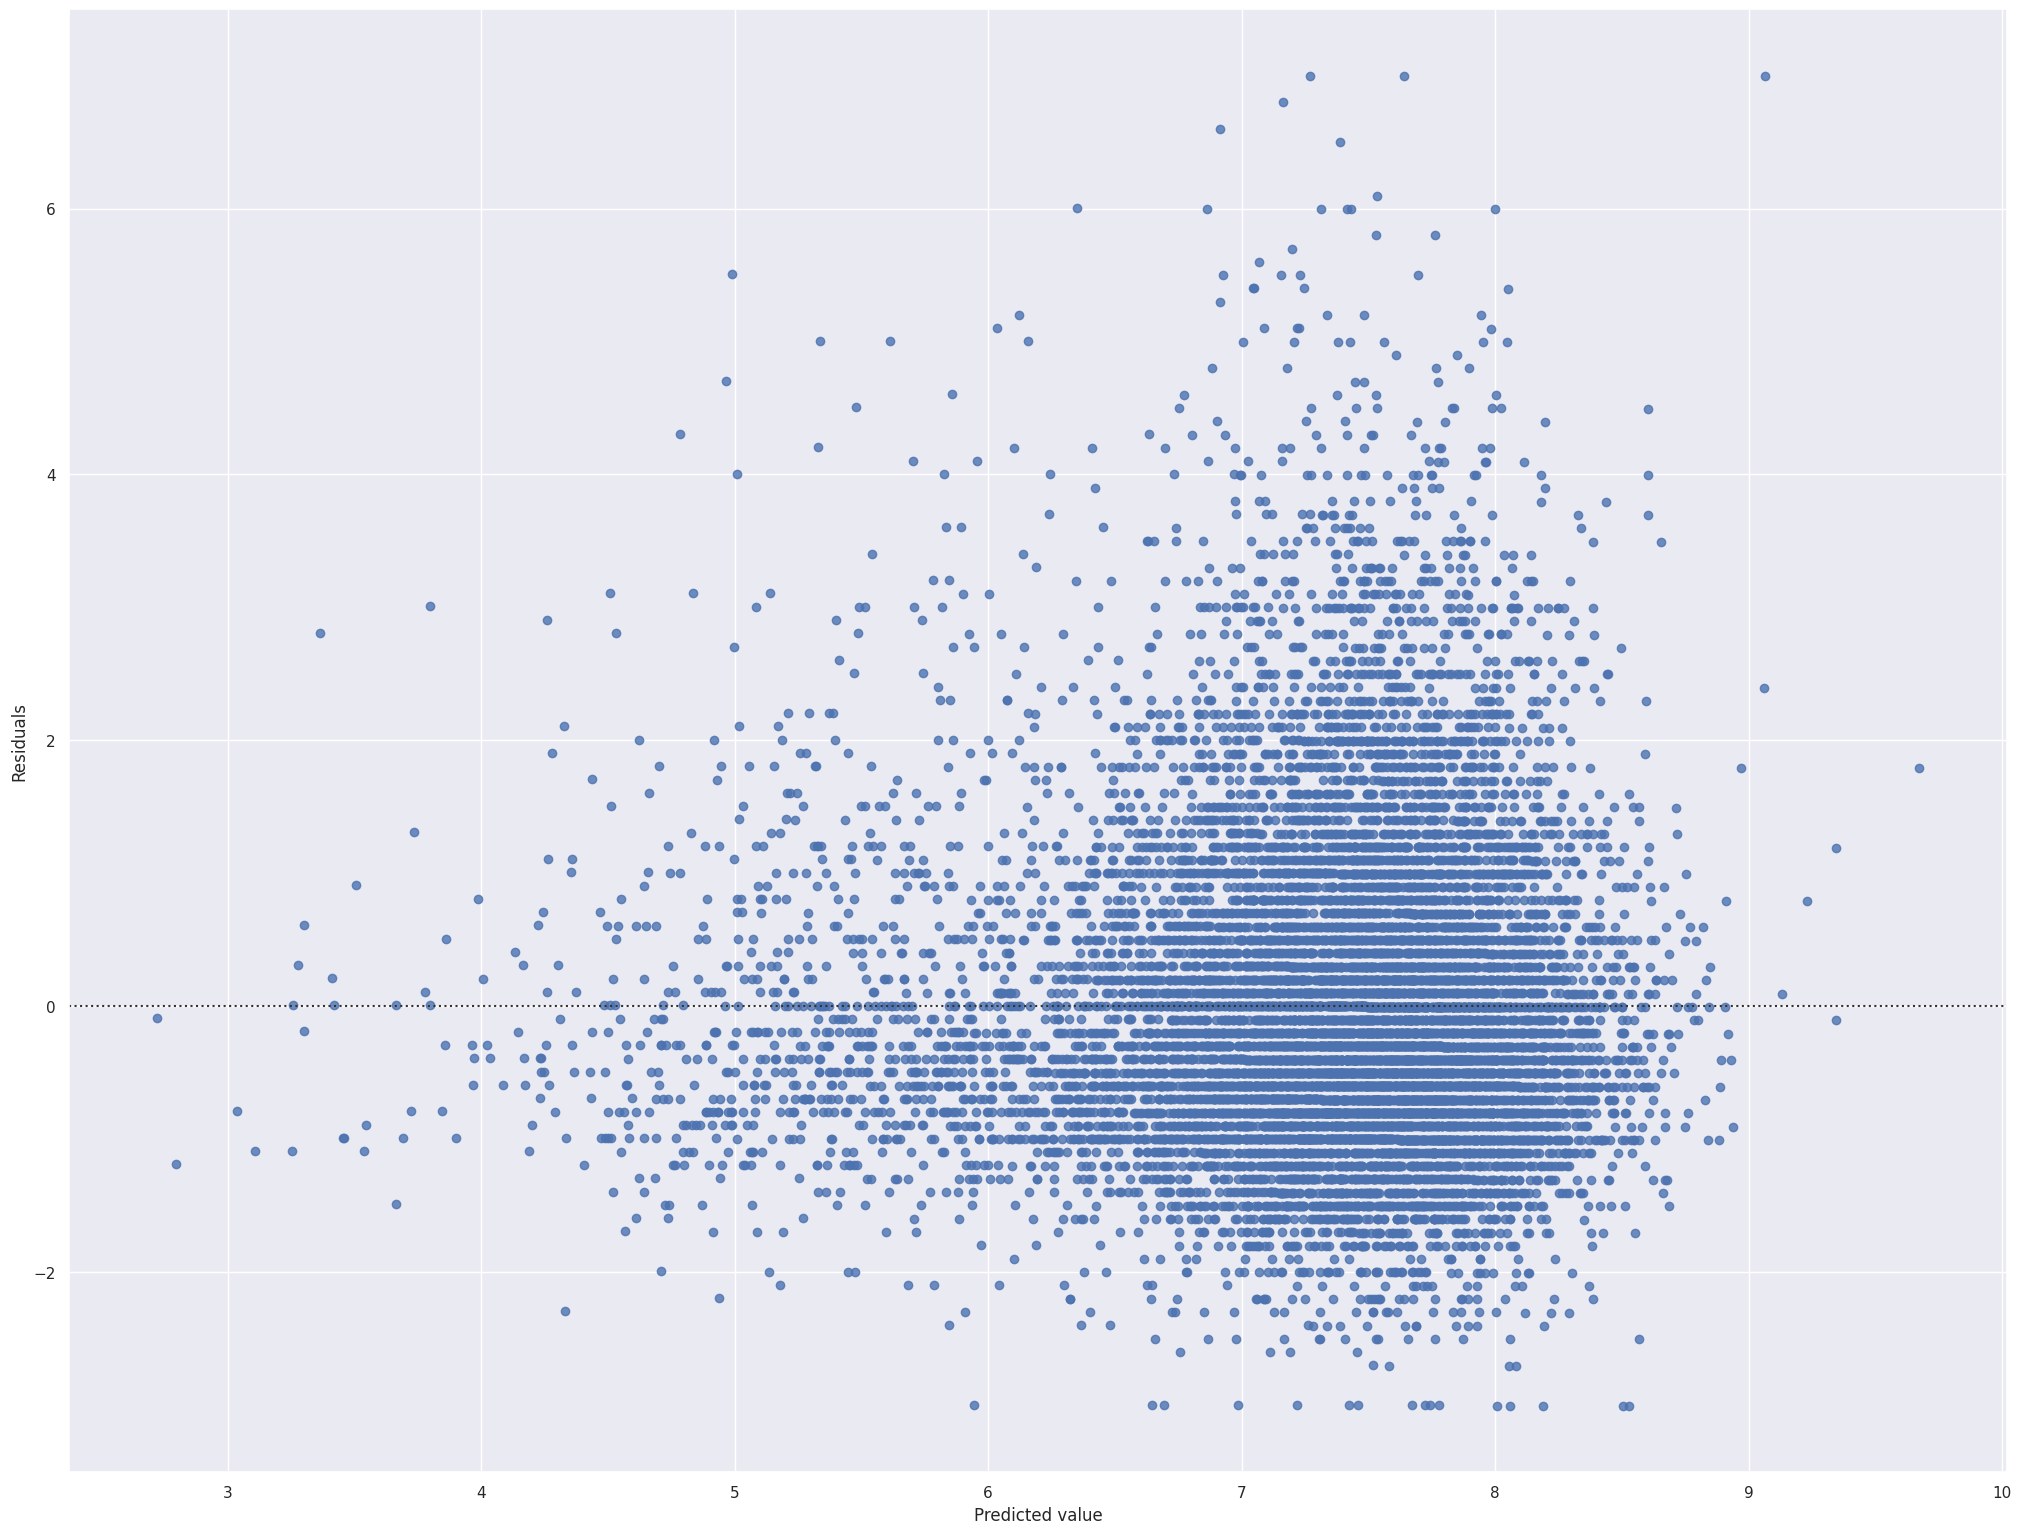

In [47]:
y_pred=reg_3.predict(x_alt_test)
residuals=y_pred-y_alt_test
df_residuals=pd.DataFrame({"Predicted value": y_pred, "Residuals": residuals})
sns.residplot(data=df_residuals, x="Predicted value", y="Residuals")
plt.show()

# 6. Hyperparameter search and cross validation 

In [48]:
# get artists with more than one album
artist_counter = df.artist.value_counts()
multi_artists = artist_counter[artist_counter > 1]

# create dict containing artist and list of albums
artists_dict = {x:[] for x in multi_artists.index}
artists_keys = artists_dict.keys()

for i, row in df.iterrows():
    if row["artist"] not in artists_keys:
        continue
    artists_dict[row["artist"]].append(row)
    
# sort all albums by releaseyear
for k, v in artists_dict.items():
    v.sort(key=lambda x: x["releaseyear"])
    

for x in artists_dict['Bonnie “Prince” Billy']:
    print(x["album"], x["releaseyear"])

I See a Darkness 1999
Get on Jolly EP 2000
Ease Down the Road 2001
Master and Everyone 2003
Greatest Palace Music 2004
Superwolf 2005
Summer in the Southeast 2005
The Brave and the Bold 2006
The Cursed Sleep EP 2006
The Letting Go 2006
Ask Forgiveness 2007
Lie Down in the Light 2008
Beware 2009
The Wonder Show of the World 2010
Island Brothers 2011
There Is No God 2011
Wolfroy Goes to Town 2011
What the Brothers Sang 2013
Singer's Grave a Sea of Tongues 2014
Epic Jammers and Fortunate Little Ditties 2016
Pond Scum 2016
Best Troubador 2017


In [65]:
print(list(artists_dict.items())[1][1][1])

artist                 Bonnie “Prince” Billy
album                        Get on Jolly EP
reviewauthor                    Ryan Kearney
score                                    7.0
releaseyear                             2000
reviewdate                 September 30 2000
recordlabel                           Palace
genre                           Folk/Country
danceability                           0.576
energy                                  0.93
key                                      1.0
loudness                              -2.349
speechiness                           0.0571
acousticness                         0.00177
instrumentalness                       0.251
liveness                               0.107
valence                                0.321
tempo                                102.996
Electronic_onehot                      False
Experimental_onehot                    False
Folk/Country_onehot                     True
Global_onehot                          False
Jazz_oneho

In [50]:
previous_scores = {}
for k, v in artists_dict.items():
    album_scores = [x["score"] for x in v]
    previous_albums_mean = mean(album_scores[:-1])
    previous_scores[k] = previous_albums_mean
dict(itertools.islice(previous_scores.items(), 4))

{'Neil Young': 7.273076923076923,
 'Bonnie “Prince” Billy': 7.385714285714286,
 'Animal Collective': 7.685,
 'Guided by Voices': 6.973684210526316}

In [51]:
df_alt = pd.DataFrame((x[-1] for x in artists_dict.values())).reset_index(drop=True)
df_alt

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,...,Electronic_onehot,Experimental_onehot,Folk/Country_onehot,Global_onehot,Jazz_onehot,Metal_onehot,Other_onehot,Pop/R&B_onehot,Rap_onehot,Rock_onehot
0,Neil Young,Colorado,Sam Sodomsky,7.4,2019,October 30 2019,none,Rock,0.905000,0.562000,...,False,False,False,False,False,False,False,False,False,True
1,Bonnie “Prince” Billy,Best Troubador,Sam Sodomsky,7.4,2017,May 9 2017,Drag City,Folk/Country,0.502375,0.210313,...,False,False,True,False,False,False,False,False,False,False
2,Animal Collective,Ballet Slippers,Grayson Haver Currin,7.4,2019,November 28 2019,none,Experimental,0.296667,0.773000,...,False,True,False,False,False,False,False,False,False,False
3,Guided by Voices,August by Cake,Saby Reyes-Kulkarni,7.1,2017,April 11 2017,GBV,Rock,0.366140,0.798250,...,False,False,False,False,False,False,False,False,False,True
4,Gucci Mane,Woptober II,Dean Van Nguyen,6.1,2019,October 24 2019,none,Rap,0.845923,0.645462,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,The Goon Sax,We’re Not Talking,Nina Corcoran,7.2,2018,September 18 2018,Wichita,Rock,0.591333,0.577333,...,False,False,False,False,False,False,False,False,False,True
3557,Brilliant Colors,Again and Again,Martin Douglas,6.8,2011,July 12 2011,Slumberland,Experimental,0.826000,0.681000,...,False,True,False,False,False,False,False,False,False,False
3558,Daniel Wohl,Holographic,Seth Colter Walls,7.7,2016,February 15 2016,New Amsterdam,Experimental,0.403500,0.971750,...,False,True,False,False,False,False,False,False,False,False
3559,Open Mike Eagle,Brick Body Kids Still Daydream,Matthew Ismael Ruiz,8.1,2017,September 19 2017,Mello Music Group,Rap,0.602167,0.656583,...,False,False,False,False,False,False,False,False,True,False


In [52]:
# create new column with score of all previous albums for specific artist
df_alt["score_previous"] = df_alt["artist"].apply(lambda x: previous_scores[x])
df_alt

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,...,Experimental_onehot,Folk/Country_onehot,Global_onehot,Jazz_onehot,Metal_onehot,Other_onehot,Pop/R&B_onehot,Rap_onehot,Rock_onehot,score_previous
0,Neil Young,Colorado,Sam Sodomsky,7.4,2019,October 30 2019,none,Rock,0.905000,0.562000,...,False,False,False,False,False,False,False,False,True,7.273077
1,Bonnie “Prince” Billy,Best Troubador,Sam Sodomsky,7.4,2017,May 9 2017,Drag City,Folk/Country,0.502375,0.210313,...,False,True,False,False,False,False,False,False,False,7.385714
2,Animal Collective,Ballet Slippers,Grayson Haver Currin,7.4,2019,November 28 2019,none,Experimental,0.296667,0.773000,...,True,False,False,False,False,False,False,False,False,7.685000
3,Guided by Voices,August by Cake,Saby Reyes-Kulkarni,7.1,2017,April 11 2017,GBV,Rock,0.366140,0.798250,...,False,False,False,False,False,False,False,False,True,6.973684
4,Gucci Mane,Woptober II,Dean Van Nguyen,6.1,2019,October 24 2019,none,Rap,0.845923,0.645462,...,False,False,False,False,False,False,False,True,False,7.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,The Goon Sax,We’re Not Talking,Nina Corcoran,7.2,2018,September 18 2018,Wichita,Rock,0.591333,0.577333,...,False,False,False,False,False,False,False,False,True,7.000000
3557,Brilliant Colors,Again and Again,Martin Douglas,6.8,2011,July 12 2011,Slumberland,Experimental,0.826000,0.681000,...,True,False,False,False,False,False,False,False,False,6.800000
3558,Daniel Wohl,Holographic,Seth Colter Walls,7.7,2016,February 15 2016,New Amsterdam,Experimental,0.403500,0.971750,...,True,False,False,False,False,False,False,False,False,7.900000
3559,Open Mike Eagle,Brick Body Kids Still Daydream,Matthew Ismael Ruiz,8.1,2017,September 19 2017,Mello Music Group,Rap,0.602167,0.656583,...,False,False,False,False,False,False,False,True,False,8.000000


In [53]:
features = [
    "releaseyear",
    "key",
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "loudness",
    "speechiness",
    "valence",
    "tempo",
    "score_previous",
] + list(hot_encoded.columns)
print(features)
print(len(features))
x = df_alt[features].values
print(x.shape)
y = df_alt["score"].values
print(y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=123)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

['releaseyear', 'key', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 'score_previous', 'Electronic_onehot', 'Experimental_onehot', 'Folk/Country_onehot', 'Global_onehot', 'Jazz_onehot', 'Metal_onehot', 'Other_onehot', 'Pop/R&B_onehot', 'Rap_onehot', 'Rock_onehot']
22
(3561, 22)
(3561,)
(2492, 22)
(1069, 22)
(2492,)
(1069,)


### Train model

In [54]:
# train new regression model with new df
model = GradientBoostingRegressor().fit(x_train, y_train)
r2 = model.score(x_test, y_test)
y_pred = model.predict(x_test)
summary(model, x_train, y_train, x_test, y_test)


 Model summary: 
train size: 2492 test size: 1069
R^2: 0.19456649560574557
Mean squared error: 1.14


0.19456649560574557

### 6.1 Hyperparameter search

In [55]:
from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators':range(100,400,100), 'learning_rate':(0.1, 0.05, 0.01)}]
model = GradientBoostingRegressor()
clf = GridSearchCV(model, parameters)
grid_result=clf.fit(x_train, y_train)

In [56]:
print(sorted(clf.cv_results_.keys()))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_learning_rate', 'param_n_estimators', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']
Best: 0.200707 using {'learning_rate': 0.01, 'n_estimators': 300}


In [57]:
# train model with best hyperparameters
model = GradientBoostingRegressor(**grid_result.best_params_)
model.fit(x_train, y_train)

r2 = model.score(x_test, y_test)
y_pred = model.predict(x_test)

In [58]:
summary(model, x_train, y_train, x_test, y_test)


 Model summary: 
train size: 2492 test size: 1069
R^2: 0.2015866460265855
Mean squared error: 1.13


0.2015866460265855

In [59]:
# use parameter grid search to find the best hyperparameters
parameters = [{'n_estimators':range(100,400,100), 'learning_rate':(0.1, 0.05, 0.01)}]
model = GradientBoostingRegressor()
params = ParameterGrid(parameters)
best_param = {'n_estimators': 100, "learning_rate": 0.1}
best_score = float("-inf")
for param in params:
    model = GradientBoostingRegressor(**param)
    model.fit(x_train, y_train)
    score = model.score(x_test, y_test)
    print(f'learning rate:{param["learning_rate"]}, number of estimators: {param["n_estimators"]}, R2:{score}')
    if score > best_score:
        best_param = param
print(f"Best params: {best_param}")

learning rate:0.1, number of estimators: 100, R2:0.19214550619597037
learning rate:0.1, number of estimators: 200, R2:0.17475224792152555
learning rate:0.1, number of estimators: 300, R2:0.1602145028396138
learning rate:0.05, number of estimators: 100, R2:0.20217808056929876
learning rate:0.05, number of estimators: 200, R2:0.19555361824895845
learning rate:0.05, number of estimators: 300, R2:0.18863418808985766
learning rate:0.01, number of estimators: 100, R2:0.1613640489497482
learning rate:0.01, number of estimators: 200, R2:0.1927927835275366
learning rate:0.01, number of estimators: 300, R2:0.20173218295776296
Best params: {'learning_rate': 0.01, 'n_estimators': 300}


In [60]:
# train model with best hyperparameters
model = GradientBoostingRegressor(**best_param)
model.fit(x_test, y_test)

r2 = model.score(x_test, y_test)
y_pred = model.predict(x_test)

In [61]:
summary(model, x_train, y_train, x_test, y_test)


 Model summary: 
train size: 2492 test size: 1069
R^2: 0.398130902935953
Mean squared error: 0.86


0.398130902935953

# K-fold validation

In [62]:
scores = []
kfold = KFold(n_splits=20)

for train_index , test_index in kfold.split(x):
    x_train , x_test = x[train_index,:], x[test_index,:]
    y_train , y_test = y[train_index], y[test_index]
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2 = model.score(x_test, y_test)
    scores.append({"r2": r2})

In [63]:
print(f"R^2 scores:")
for score in scores:
    print(score['r2'])

R^2 scores:
0.2143184059534764
0.09317809947761324
0.23535378292310705
0.2890925104225104
0.23058016474728782
0.06292256273735686
0.29182798634276375
0.3135383442151043
0.25063195030043484
0.25263283877980514
0.26930550766748573
0.12152076179568749
0.20383107790208632
0.306941550598659
0.1581260930201589
0.09243713516441054
0.21636040029323078
0.25768025359592517
0.1725446445527543
0.016236370313674975


# the higher the R-squared, the better the model fits your data